In [1]:
import pymc3 as pm
import theano.tensor as TT
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj

import pandas as pd
import seaborn as sns

import cuentitas
from cuentitas import a0VV, a1VVF1, a1VVF2

from auxiliares import integracionGauss as ig
from auxiliares import medicion
from auxiliares import sigmaHH, sigmaVV

sns.set()

In [20]:
#No importa este
def toFitVV2(ep1,ep2,d,s1,l1,s2,l2,angulo,landa):

    k0 = 2*np.pi/landa
    phi = np.pi
    
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
 
    a = TT.zeros(1)
    aa = TT.set_subtensor(a[0], s0s)
 
    return aa


In [21]:
#Un unico angulo de incidencia
def toFitHHVV(ep1,ep2,d,s1,l1,s2,l2,angulo,landa):
    if (ep1 != ep2):
        s0HH = sigmaHH(ep1,ep2,d,s1,l1,s2,l2,angulo,landa)
        s0VV = sigmaVV(ep1,ep2,d,s1,l1,s2,l2,angulo,landa)
     
        a = TT.zeros(2)
        aa = TT.set_subtensor(a[0], s0HH)
        aaa = TT.set_subtensor(aa[1],s0VV)
    
    return aaa


In [2]:
def toFitHHVV(ep1,ep2,d,s1,l1,s2,l2,angulo,landa):
    if (ep1 != ep2):
        s0HH = sigmaHH(ep1,ep2,d,s1,l1,s2,l2,angulo,landa)
        s0VV = sigmaVV(ep1,ep2,d,s1,l1,s2,l2,angulo,landa)
        
        
        hh = len(angulo)
        vv = len(angulo)
        
        a = TT.zeros(hh+vv)
     
               #Ordeno primero s0HH y s0VV
        for i in range(hh):
            a = TT.set_subtensor(a[i], s0HH[i])
        for j in range(vv):
            a = TT.set_subtensor(a[hh+j], s0VV[j])
    return a #Devuelve primero los n HH y luego los n VV (n = len(angulo))

In [3]:
a = toFitHHVV(3,5,0.04,0.001,0.01,0.0014,0.014,np.asarray([20,30]),0.0235)
a.eval()

array([ -9.74121908, -14.2478736 ,  -9.11614618, -13.42509099])

In [4]:
sigmaHH(3,5,0.04,0.001,0.01,0.0014,0.014,np.asarray([20,30]),0.0235)

array([ -9.74121908, -14.2478736 ])

In [3]:
def modelo(data, samples, sigmas, landa, angulo):
 
    k0 = 2*np.pi/landa
    phi = np.pi
 
    ranges = {}
    ranges['ep1'] = 3, 10
    ranges['ep2'] = 8, 30
    ranges['d'] = 0.05, 0.2
    ranges['s1'] = 0.0025, 0.02
    ranges['l1'] = 0.005, 0.04
    ranges['s2'] = 0.001, 0.01
    ranges['l2'] = 0.005, 0.03
 
    # with pm.Model() as model:
    #     ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
    #     ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
    #     d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
    #     s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
    #     # l1 = pm.Uniform('l1', ranges['l1'][0], ranges['l1'][1])
    #     s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])
    #     # l2 = pm.Uniform('l2', ranges['l2'][0], ranges['l2'][1])

        
    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Normal('s1', mu = 0.91, sigma = (0.23**2))
        # l1 = pm.Normal('l1', mu = 1.71, sigma = (0.75**2))
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])
        l2 = pm.Uniform('l2', ranges['l2'][0], ranges['l2'][1])
        
    #impongo l1 = 10*s1 y lo mismo en 2

    def f(ep1 = ep1, 
          ep2 = ep2, 
          d = d, 
          s1 = s1, 
          # l1 = l1,
          s2 = s2,
          l2 = l2
         ):
        return toFitHHVV(ep1,ep2,d,s1,2*s1,s2,l2,angulo,landa)
 
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=data)
        trace = pm.sample_smc(samples, cores=4, parallel=True)
    
    return trace


In [65]:
angIncMean = 32.720337
fac = 10
s0mean = np.asarray([-18.93731932906163, -16.864187843079993])
landa = 0.235
sigmas = np.asarray([1.6142518086419742/fac, 1.9713870091998071/fac])

In [8]:
angIncMean = [32.353413, 32.353386, 32.35336, 32.35333, 32.353306, 32.34991, 32.349884, 32.349854, 32.349823, 32.3498, 32.346397, 32.346375, 32.346348, 32.346317, 32.346294, 32.342896, 32.34287, 32.342842, 32.342815, 32.34279, 32.33939, 32.339367, 32.339336, 32.33931, 32.339283] 

s0meanHHVV = [[-13.137722816558037, -13.13866345026846, -13.038583148122173, -13.005425621097132, -13.05172759986867, -12.982577164692009, -12.929200399483019, -13.105266038980002, -13.146179418824808, -13.060892229894423, -13.29593236903258, -13.199827910712422, -13.125048456152376, -12.942176404357475, -13.159321766363615, -13.196640519317032, -13.47970244908132, -13.494886284976966, -13.354579126627428, -13.264016547920495, -13.90592172779473, -13.931682288339355, -14.079205146927496, -13.958616288721835, -13.937516824324268], [-11.646683581483083, -11.72239521609055, -11.550244240482698, -11.635706744461103, -11.788468660212386, -11.594784339330944, -11.43860269663905, -11.38345603716363, -11.300224537204485, -11.316774706206456, -11.650604882797825, -11.646701067103042, -11.455027185559478, -11.292559770415528, -11.491180277683734, -11.427240621693885, -11.722853058468488, -11.83286279677955, -11.89910957391637, -11.758749329573135, -12.235360665492728, -12.238589997272742, -12.296340228327463, -12.152175110133038, -12.232390605130796]] 

sigmasHHVV = [[1.4279072991033113, 1.351747022303371, 1.4626112354663425, 1.4879937230486169, 1.4875111172625466, 1.3069381717776118, 1.1977392100104567, 1.4284253332641852, 1.5824653565646445, 1.4307252086764117, 1.5157824753700173, 1.2785881219854556, 1.6680827203599902, 1.8096471906029183, 1.6178562546424609, 1.2427314639460862, 1.3995730576358532, 1.3721865477112076, 1.437827486446846, 1.381090503150927, 1.5632513088910522, 1.529930373731063, 1.3283188430345205, 1.4641366201716766, 1.5993975311741684], [1.325687058423977, 1.2448047511259466, 1.4361944063478165, 1.5384460870952157, -1.3760576326687566, 1.40760514876525, 1.3950203870437883, 1.349148235869482, 1.3380896078419278, 1.4920509044943857, 1.5611949296763823, 1.3163560471579872, 1.6456461129647486, 1.7922834732400974, 1.7794576834469429, 1.4006082056225078, 1.3805118723954295, 1.3130727360319108, 1.5236005139772322, 1.557314488527298, 1.5531518805358497, 1.7267132281287383, 1.449461447905268, 1.47166480399219, 1.536838119084037]]

angIncMean = np.asarray(angIncMean)
s0meanHHVV = np.asarray(s0meanHHVV).flatten()
sigmasHHVV = np.abs(np.asarray(sigmasHHVV).flatten())
landa = 0.235

In [9]:
angIncMean

array([32.353413, 32.353386, 32.35336 , 32.35333 , 32.353306, 32.34991 ,
       32.349884, 32.349854, 32.349823, 32.3498  , 32.346397, 32.346375,
       32.346348, 32.346317, 32.346294, 32.342896, 32.34287 , 32.342842,
       32.342815, 32.34279 , 32.33939 , 32.339367, 32.339336, 32.33931 ,
       32.339283])

In [6]:
# angIncMean = np.loadtxt('InputsInferencia/angulosRukamay1-imagen.txt', delimiter = ';')
# s0meanHHVV = np.loadtxt('InputsInferencia/S0HHVVRukamay1-imagen.txt', delimiter = ';')
# sigmasHHVV = np.sqrt(np.abs(np.loadtxt('InputsInferencia/sigmasHHVVRukamay1-imagen.txt', delimiter = ';')))

# angIncMean = np.loadtxt('InputsInferencia/angulosBarrancosa1-imagen.txt', delimiter = ';')
# s0meanHHVV = np.loadtxt('InputsInferencia/S0HHVVBarrancosa1-imagen.txt', delimiter = ';')
# sigmasHHVV = np.sqrt(np.abs(np.loadtxt('InputsInferencia/sigmasHHVVBarrancosa1-imagen.txt', delimiter = ';')))

angIncMean = np.loadtxt('InputsInferencia/angulosBarrancosa2-imagen.txt', delimiter = ';')
s0meanHHVV = np.loadtxt('InputsInferencia/S0HHVVBarrancosa2-imagen.txt', delimiter = ';')
sigmasHHVV = np.sqrt(np.abs(np.loadtxt('InputsInferencia/sigmasHHVVBarrancosa2-imagen.txt', delimiter = ';')))


lote = 1

landa = 0.235

In [7]:
s0meanHHVV

array([-18.77468554, -18.97578447, -19.03567182, -18.68322688,
       -18.64502316, -18.82940029, -18.73105359, -18.87129904,
       -18.78313993, -18.82747878, -19.28696329, -19.43918531,
       -19.42949311, -18.98261514, -18.94926886, -19.61817813,
       -19.62328369, -19.80990636, -19.88084952, -19.85292046,
       -19.11664914, -18.9202383 , -18.98404254, -18.88809896,
       -19.13926218, -16.63701825, -16.68735692, -16.57991449,
       -16.60987874, -16.56288169, -16.72980102, -16.70137522,
       -16.45450141, -16.59839596, -16.76852338, -16.04856042,
       -16.29854387, -16.46070811, -16.63258328, -16.09290595,
       -16.78437381, -16.54360095, -16.64339902, -16.84845057,
       -16.88700789, -16.33804172, -16.08406025, -16.12824049,
       -16.21625875, -16.26983089])

In [8]:
print(len(angIncMean),len(s0meanHHVV),len(sigmasHHVV))

25 50 50


In [9]:
# samples = 1000
# traza = modelo(s0mean, samples, sigmas, landa, angIncMean)

samples = 5000
traza = modelo(s0meanHHVV, samples, sigmasHHVV, landa, angIncMean)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. 

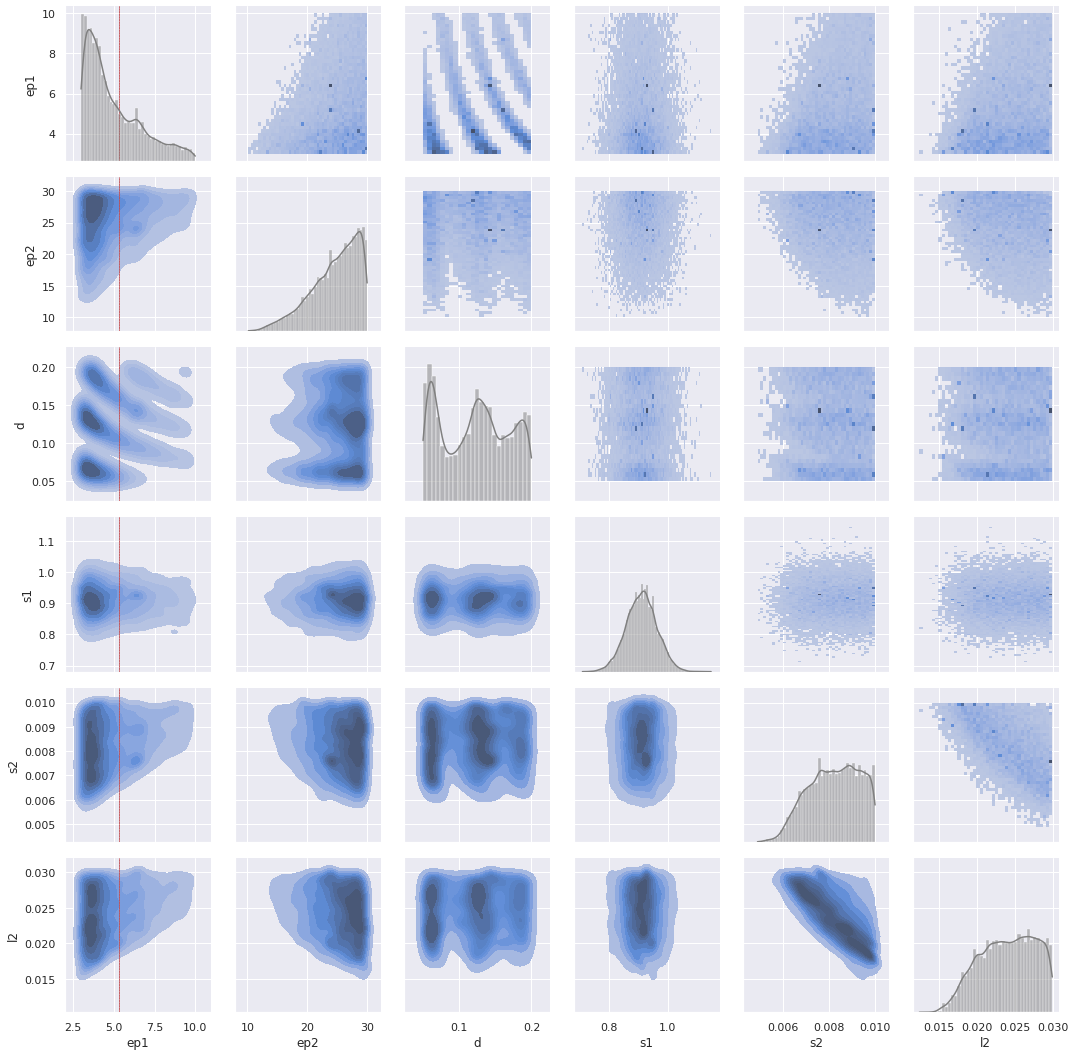

In [10]:
# plotear = np.stack((traza['ep1'], traza['ep2'], traza['d'], traza['s1'], traza['l1'], traza['s2'], traza['l2'])).T 
# dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','l1','s2','l2'])

plotear = np.stack((traza['ep1'], traza['ep2'], traza['d'], traza['s1'], traza['s2'], traza['l2'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','s2','l2'])

# inp = np.loadtxt('InputsInferencia/humedadmediaRukamay1.txt')
# inp = np.loadtxt('InputsInferencia/humedadmediaBarrancosa1.txt')
inp = np.loadtxt('InputsInferencia/humedadmediaBarrancosa2.txt')

humedadMedida = inp[0]

error = inp[1]

g = sns.PairGrid(dfplotear)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
for i in range(6):
    g.axes[i,0].axvline(humedadMedida, color='r', linestyle='solid', linewidth=0.5)
    g.axes[i,0].axvline(humedadMedida+error, color='r', linestyle='dashed', linewidth=0.5)
    g.axes[i,0].axvline(humedadMedida-error, color='r', linestyle='dashed', linewidth=0.5)
    
# for i in range(4):
#     g.axes[0,i+1].axhline(humedadMedida, color='r', linestyle='dashed', linewidth=1)

In [11]:
# g.savefig('Graficos/100s0HHVV-m='+str(samples)+'Rukamay1-imagen-Normal-todos.png',dpi=300)
# g.savefig('Graficos/100s0HHVV-m='+str(samples)+'Barrancosa1-imagen-Normal-todos.png',dpi=300)
g.savefig('Graficos/100s0HHVV-m='+str(samples)+'Barrancosa2-imagen-Normal-todos.png',dpi=300)

In [18]:
# g.savefig('Graficos/200s0HHVV-lote'+str(lote)+'-m='+str(samples)+'Rukamay1.png',dpi=300)